<a href="https://colab.research.google.com/github/Mikaner/reinforcement/blob/main/CartPole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get -qq -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1 > /dev/null
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!apt -qq install xvfb freeglut3-dev ffmpeg> /dev/null
!pip -q install gym
!pip -q install JSAnimation
!pip -q install pyglet
!pip -q install pyopengl
!pip -q install pyvirtualdisplay

E: Unable to locate package libcusparse8.0
E: Couldn't find any package by glob 'libcusparse8.0'
E: Couldn't find any package by regex 'libcusparse8.0'
E: Unable to locate package libnvrtc8.0
E: Couldn't find any package by glob 'libnvrtc8.0'
E: Couldn't find any package by regex 'libnvrtc8.0'




In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = f":{display.display}"
# https://github.com/ponty/PyVirtualDisplay/issues/54

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym

In [ ]:
# 動画の描画関数の宣言
# 参考URL: http://nbviewer.jupyter.org/github/patrickmineault/xcorr-notebooks/blob/master/Render%20OpenAI%20gym%20as%20GIF.ipynb
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
#from IPython.display import display
from IPython.display import HTML

def make_anim(frames):
    plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), 
               dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])
    
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames),
                                   interval=50)
    return anim

def save_frames_as_gif(frames):
    """
    DISPLAYs a list of frames as a gif, with controls
    """
    
    anim = make_anim(frames)
    anim.save('movie_cartpole.mp4')
    #display(display_animation(anim, default_mode='loop'))
    return anim.to_jshtml()

In [ ]:
frames = []
env = gym.make('CartPole-v0')
observation = env.reset()

for step in range(0, 200):
    frames.append(env.render(mode='rgb_array'))
    action = np.random.choice(2)
    observation, reward, done, info = env.step(action)

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


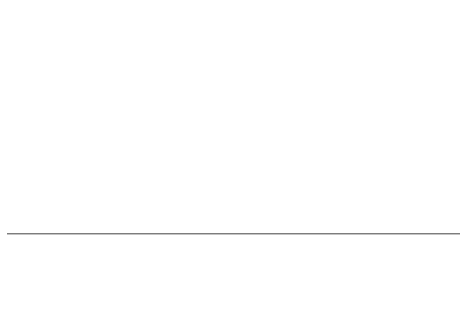

In [ ]:
# display_frames_as_gif(frames) の代わり
HTML(save_frames_as_gif(frames))
# HTML(make_anim(frames)) # saveがいらない場合はこっち

In [ ]:
ENV = 'CartPole-v0'
NUM_DIZITIZED = 6

env = gym.make(ENV)
observation = env.reset()

In [ ]:
def bins(clip_min, clip_max, num):
    '''観測した状態(連続値)を離散値にデジタル変換する閾値を求める'''
    return np.linspace(clip_min, clip_max, num + 1)[1:-1]

In [ ]:
def digitize_state(observation):
    cart_pos, cart_v, pole_angle, pole_v = observation
    digitized = [
        np.digitize(cart_pos, bins=bins(-2.4, 2.4, NUM_DIZITIZED)),
        np.digitize(cart_v, bins=bins(-3.0, 3.0, NUM_DIZITIZED)),
        np.digitize(pole_angle, bins=bins(-0.5, 0.5, NUM_DIZITIZED)),
        np.digitize(pole_v, bins=bins(-2.0, 2.0, NUM_DIZITIZED))
    ]
    return sum([x * (NUM_DIZITIZED**i)for i, x in enumerate(digitized)]) # NUM_DIZITIZED進数へ変換

In [ ]:
ENV = 'CartPole-v0'
NUM_DIZITIZED = 6
GAMMA = 0.99
ETA = 0.5
MAX_STEPS = 200
NUM_EPISODES = 100

In [ ]:
class Agent:
    '''CartPoleのエージェントクラスです、棒付き台車そのものになります'''
    def __init__(self, num_states, num_actions):
        self.brain = Brain(num_states, num_actions)
        # エージェントが行動を決定するための頭脳を生成
        # 継承した方が良くね？と思わないこともない

    def update_Q_function(self, observation, action, reward, observation_next):
        '''Q関数の更新'''
        self.brain.update_Q_table(
            observation, action, reward, observation_next
        )
    
    def get_action(self, observation, step):
        '''行動の決定'''
        action = self.brain.decide_action(observation, step)
        return action

In [ ]:
class Brain:
    '''エージェントが持つ脳となるクラスです。Q学習を実行します'''

    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions # CartPoleの行動(右に左に押す)の2を取得

        # Qテーブルを作成。
        # 行数は状態を分割数^(4変数)にデジタル変換した値、列数は行動数を示す
        self.q_table = np.random.uniform(low=0, high=1, size=(
            NUM_DIZITIZED**num_states, num_actions
        ))
        # NUM_DIZITIZEDはクラスのインスタンス定数にした方が良くね？と思わないこともない

    def bins(self, clip_min, clip_max, num):
        '''観測した状態(連続値)を離散的にデジタル変換する閾値を求める'''
        return np.linespace(clip_min, clip_max, num + 1)[1:-1]

    def digitize_state(self, observation):
        '''観測したobservation状態を、離散値に変換する'''
        cart_pos, cart_v, pole_angle, pole_v = observation
        digitized = [
            np.digitize(  cart_pos, bins=self.bins(-2.4, 2.4, NUM_DIZITIZED)),
            np.digitize(    cart_v, bins=self.bins(-3.0, 3.0, NUM_DIZITIZED)),
            np.digitize(pole_angle, bins=self.bins(-0.5, 0.5, NUM_DIZITIZED)),
            np.digitize(    pole_v, bins=self.bins(-2.0, 2.0, NUM_DIZITIZED))
        ]
        return sum([x * (NUM_DIZITIZED**i) for i, x in enumerate(digitized)])

    def update_Q_table(self, observation, action, reward, observation_next):
        '''QテーブルをQ学習により更新'''
        state = self.digitize_state(observation)
        state_next = self.digitize_state(observation_next)
        Max_Q_next = max(self.q_table[state_next][:])
        self.q_table[state, action] = self.q_table[state, action] + \
            ETA * (reward + GAMMA * Max_Q_next - self.q_table[state, action])
        
    def decide_action(self, observation, episode):
        '''ε-greedy法で徐々に最適行動のみを採用する'''
        state = self.digitize_state(observation)
        epsilon = 0.5 * (1 / (episode + 1)) # エピソードが進むにつれてランダムの確率を減らす

        if epsilon <= np.random.uniform(0, 1):
            action = np.argmax(self.q_table[state][:])
        else:
            action = np.random.choice(self.num_actions) # 0,1の行動をランダムに返す
        return action

In [ ]:
class Environment:
    '''CartPoleを実行する環境のクラスです'''

    def __init__(self):
        self.env = gym.make(ENV) # 実行する課題を設定
        num_states = self.env.observation_space.shape[0] # 課題の状態の数4を取得
        num_actions = self.env.action_space.n # CartPoleの行動(右左に押す)の2を取得

        self.agent = Agent(num_states, num_actions)

    def run(self):
        '''実行'''
        complete_episodes = 0 # 195step以上連続で立ち続けた試行数
        is_episode_final = False
        frames = [] # 動画用の画像を格納する変数

        for episode in range(NUM_EPISODES): # NUM_EPISODESはEnvironmentのinitで初期化する方が良くねと思ったり思わなかったり
            observation = self.env.reset()

            for step in range(MAX_STEPS): # 1エピソード内のループ
                if is_episode_final: # 最終試行では動画を記録するために各時刻の画像を追加していく
                    frames.append(self.env.render(mode='rgb_array'))
                
                action = self.agent.get_action(observation, episode)
                # 行動a_tの実行により、s_{t+1}, r_{t+1}を求める
                observation_next, _, done, _ = self.env.step(action) # reward と info は使用しない
                
                # 報酬を与える
                